In [1]:
import os,codecs
import pandas as pd
import nltk
from nltk import*
import matplotlib.pyplot as plt
import string
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

# Data Cleaning

In [2]:
df = pd.read_csv("XED.txt",  error_bad_lines=False, sep= '\t', header= None, names = ["sent", "label_1"])
df.head()

,sent,label_1
0,", ...",1
1,!,"1, 4, 7"
2,... And I don't think we need to discuss the T...,"8, 1"
3,* So get up out of your bed,1
4,A confession that you hired [PERSON] ... and a...,"1, 6"


In [3]:
df[["label_1", "label_2"]] = df['label_1'].str.split(",", 1, expand=True)
df[["label_2", "label_3"]] = df['label_2'].str.split(",", 1, expand=True)

In [4]:
df["label_1"] = pd.to_numeric(df["label_1"])
df["label_2_fill"] = np.where(df.label_2.isnull(), df.label_1, df.label_2)
df["label_2_fill"] = pd.to_numeric(df["label_2_fill"])

In [5]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [6]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
               
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    table = str.maketrans('', '', string.punctuation)
    lst_text = [w.translate(table) for w in lst_text]
                   
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
df["text_clean"] = df["sent"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords= lst_stopwords))

In [8]:
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row["text_clean"]), axis=1)
df.head()

,sent,label_1,label_2,label_3,label_2_fill,text_clean,tokenized_sents
0,", ...",1,None,None,1,,[]
1,!,1,4,7,4,,[]
2,... And I don't think we need to discuss the T...,8,1,None,1,and i dont think we need to discuss the trinit...,"[and, i, dont, think, we, need, to, discuss, t..."
3,* So get up out of your bed,1,None,None,1,so get up out of your bed,"[so, get, up, out, of, your, bed]"
4,A confession that you hired [PERSON] ... and a...,1,6,None,6,a confession that you hired person and are res...,"[a, confession, that, you, hired, person, and,..."


In [9]:
h = df[df["text_clean"] == ""]
h.shape

(3, 7)

# The Hit Rate of Vader (18.134 %)

In [10]:
file = "vader_lexicon.txt"
vader_df = pd.read_csv(file,  names=["word", "value_1", "value_2", "list"], skiprows=45, sep='\t')
vader_df.head()

,word,value_1,value_2,list
0,);<,-2.6,0.80000,"[-2, -2, -2, -3, -2, -3, -2, -2, -4, -4]"
1,*),0.6,1.42829,"[1, -1, 1, -3, 1, 1, 2, 1, 1, 2]"
2,*-),0.3,1.61555,"[1, -3, -2, 2, 1, 1, -1, 2, 1, 1]"
3,*-:,2.1,1.51327,"[2, 2, 4, 4, 2, 1, -1, 4, 1, 2]"
4,*-;,2.4,1.62481,"[2, 3, 4, 4, 2, 1, -1, 4, 1, 4]"


In [11]:
vader_df.shape

(7475, 4)

In [12]:
word_list = []
for sent in df.tokenized_sents:
    for word in sent:
        word_list.append(word)
        
print("the length of the list word_list", len(word_list))
print("the length of the set word_list", len(set(word_list)))

the length of the list word_list 130534
the length of the set word_list 8586


In [13]:
vader_words = []
for word in vader_df.word:
    vader_words.append(word)
print(len(vader_words))

7475


In [14]:
match_vader = []
for word in set(word_list):
    if word in vader_words:
        match_vader.append(word)
print(len(match_vader))

1557


In [15]:
print("The hit rate of Vader = ", round(len(match_vader)*100/len(set(word_list)),3), "%)")

The hit rate of Vader =  18.134 %)


# Evaluating the Performance of Vader

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
     
    
    if sentiment_dict['compound'] >= 0.05 : 
        return 1 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        return -1 
  
    else : 
        return 0


In [18]:
polarity = []
for sent in df.text_clean:
    polarity.append(sentiment_scores(sent))

In [19]:
len(polarity)

17528

In [20]:
df["polarity"] = polarity

In [21]:
df.head()

,sent,label_1,label_2,label_3,label_2_fill,text_clean,tokenized_sents,polarity
0,", ...",1,None,None,1,,[],0
1,!,1,4,7,4,,[],0
2,... And I don't think we need to discuss the T...,8,1,None,1,and i dont think we need to discuss the trinit...,"[and, i, dont, think, we, need, to, discuss, t...",0
3,* So get up out of your bed,1,None,None,1,so get up out of your bed,"[so, get, up, out, of, your, bed]",0
4,A confession that you hired [PERSON] ... and a...,1,6,None,6,a confession that you hired person and are res...,"[a, confession, that, you, hired, person, and,...",-1


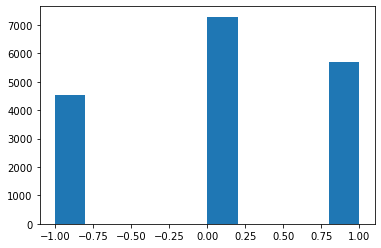

In [22]:
plt.hist(df["polarity"]);

In [23]:
df.polarity.value_counts()

 0    7291
 1    5686
-1    4551
Name: polarity, dtype: int64

In [24]:
df = df[["text_clean", "label_1", "label_2_fill", "polarity"]]

In [25]:
df["label_polarity"] = df["label_1"].map({1:-1, 2:1, 3:-1, 4:-1, 5:1, 6:-1, 7:-1, 8:1})

In [26]:
df["label_polarity"].value_counts()

-1    10291
 1     7237
Name: label_polarity, dtype: int64

In [27]:
def print_accuracy(df, pred_column):
    "Print f1 score and accuracy after making predictions"
    f1_macro = f1_score(df["label_polarity"], df[pred_column], average='macro')
    acc = accuracy_score(df["label_polarity"], df[pred_column])*100
    return f1_macro, acc

In [28]:
acc = print_accuracy(df, "polarity")
print("Macro F1-score: {}\nAccuracy: {}".format(round(acc[0], 3), round(acc[1], 3)))

Macro F1-score: 0.358
Accuracy: 42.412


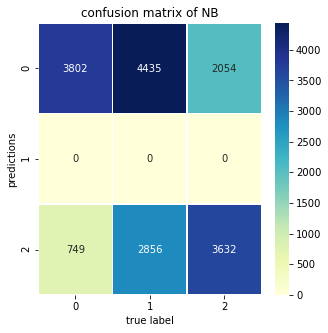

In [29]:
confusion_matrix = metrics.confusion_matrix(df.label_polarity, df.polarity)
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt= 'd',ax=ax, cmap="YlGnBu");
plt.title("confusion matrix of NB")
plt.xlabel("true label");
plt.ylabel("predictions");

# After removing the neutral datapoints

In [30]:
df_pol = df[df.polarity != 0]
df_pol.shape

(10237, 5)

In [31]:
#After removing the neutral
acc = print_accuracy(df, "polarity")
print("Macro F1-score: {}\nAccuracy: {}".format(round(acc[0], 3), round(acc[1], 3)))

Macro F1-score: 0.358
Accuracy: 42.412


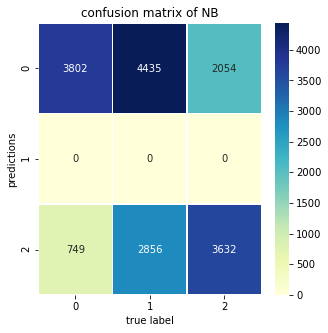

In [32]:
confusion_matrix = metrics.confusion_matrix(df.label_polarity, df.polarity)
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt= 'd',ax=ax, cmap="YlGnBu");
plt.title("confusion matrix of NB")
plt.xlabel("true label");
plt.ylabel("predictions");

# Classification

In [33]:
df.shape

(17528, 5)

In [34]:
df.polarity.value_counts()

 0    7291
 1    5686
-1    4551
Name: polarity, dtype: int64

In [35]:
df.label_polarity.value_counts()

-1    10291
 1     7237
Name: label_polarity, dtype: int64

In [36]:
df.shape

(17528, 5)

In [37]:
df.head()

,text_clean,label_1,label_2_fill,polarity,label_polarity
0,,1,1,0,-1
1,,1,4,0,-1
2,and i dont think we need to discuss the trinit...,8,1,0,1
3,so get up out of your bed,1,1,0,-1
4,a confession that you hired person and are res...,1,6,-1,-1


In [38]:
X = df["text_clean"]
y_target = df["polarity"]
y_label = df["label_polarity"]

X_train, X_test, y_train_t, y_test_t, y_train_l, y_test_l = train_test_split(X, y_target, y_label, test_size=0.30, random_state=42)

In [39]:
# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# LogisticRegression 
text_clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

In [40]:
print("Report of MultinomialNB, vader polarity")
text_clf_nb.fit(X_train, y_train_t)
predictions = text_clf_nb.predict(X_test)
print("Confusion Matrix \n",metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of MultinomialNB, vader polarity
Confusion Matrix 
 [[ 637 1815  648]
 [   0    0    0]
 [ 118 1093  948]]
              precision    recall  f1-score   support

          -1       0.84      0.21      0.33      3100
           0       0.00      0.00      0.00         0
           1       0.59      0.44      0.50      2159

    accuracy                           0.30      5259
   macro avg       0.48      0.21      0.28      5259
weighted avg       0.74      0.30      0.40      5259

Accuracy Score:  0.3013880965963111


C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
print("Report of LinearSVC, vader polarity")
text_clf_lsvc.fit(X_train, y_train_t)
predictions = text_clf_lsvc.predict(X_test)
print("Confusion Matrix \n", metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of LinearSVC, vader polarity
Confusion Matrix 
 [[ 973 1512  615]
 [   0    0    0]
 [ 238  937  984]]
              precision    recall  f1-score   support

          -1       0.80      0.31      0.45      3100
           0       0.00      0.00      0.00         0
           1       0.62      0.46      0.52      2159

    accuracy                           0.37      5259
   macro avg       0.47      0.26      0.33      5259
weighted avg       0.73      0.37      0.48      5259

Accuracy Score:  0.3721239779425746


In [42]:
print("Report of LogisticRegression, vader polarity")
text_clf_lr.fit(X_train, y_train_t)
predictions = text_clf_lr.predict(X_test)
print("Confusion Matrix \n", metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of LogisticRegression, vader polarity
Confusion Matrix 
 [[ 863 1668  569]
 [   0    0    0]
 [ 218 1009  932]]
              precision    recall  f1-score   support

          -1       0.80      0.28      0.41      3100
           0       0.00      0.00      0.00         0
           1       0.62      0.43      0.51      2159

    accuracy                           0.34      5259
   macro avg       0.47      0.24      0.31      5259
weighted avg       0.73      0.34      0.45      5259

Accuracy Score:  0.3413196425175889


C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# For the 2nd Label

In [43]:
df["label_polarity_2"] = df["label_2_fill"].map({1:-1, 2:1, 3:-1, 4:-1, 5:1, 6:-1, 7:-1, 8:1})

In [44]:
X = df["text_clean"]
y_target = df["polarity"]
y_label = df["label_polarity_2"]

X_train, X_test, y_train_t, y_test_t, y_train_l, y_test_l = train_test_split(X, y_target, y_label, test_size=0.30, random_state=42)

In [45]:
df.label_polarity_2.value_counts()

-1    10692
 1     6836
Name: label_polarity_2, dtype: int64

In [46]:
print("Report of MultinomialNB, vader polarity label_2")
text_clf_nb.fit(X_train, y_train_t)
predictions = text_clf_nb.predict(X_test)
print("Confusion Matrix \n",metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of MultinomialNB, vader polarity label_2
Confusion Matrix 
 [[ 645 1880  684]
 [   0    0    0]
 [ 110 1028  912]]
              precision    recall  f1-score   support

          -1       0.85      0.20      0.33      3209
           0       0.00      0.00      0.00         0
           1       0.57      0.44      0.50      2050

    accuracy                           0.30      5259
   macro avg       0.48      0.22      0.28      5259
weighted avg       0.74      0.30      0.39      5259

Accuracy Score:  0.29606389047347403


C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print("Report of LinearSVC, vader polarity label_2")
text_clf_lsvc.fit(X_train, y_train_t)
predictions = text_clf_lsvc.predict(X_test)
print("Confusion Matrix \n", metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of LinearSVC, vader polarity label_2
Confusion Matrix 
 [[ 986 1564  659]
 [   0    0    0]
 [ 225  885  940]]
              precision    recall  f1-score   support

          -1       0.81      0.31      0.45      3209
           0       0.00      0.00      0.00         0
           1       0.59      0.46      0.52      2050

    accuracy                           0.37      5259
   macro avg       0.47      0.26      0.32      5259
weighted avg       0.73      0.37      0.47      5259

Accuracy Score:  0.3662293211637193


In [48]:
print("Report of LogisticRegression, vader polarity label_2")
text_clf_lr.fit(X_train, y_train_t)
predictions = text_clf_lr.predict(X_test)
print("Confusion Matrix \n", metrics.confusion_matrix(y_test_l,predictions))
print(metrics.classification_report(y_test_l,predictions))
print("Accuracy Score: ", metrics.accuracy_score(y_test_l,predictions))

Report of LogisticRegression, vader polarity label_2
Confusion Matrix 
 [[ 878 1723  608]
 [   0    0    0]
 [ 203  954  893]]
              precision    recall  f1-score   support

          -1       0.81      0.27      0.41      3209
           0       0.00      0.00      0.00         0
           1       0.59      0.44      0.50      2050

    accuracy                           0.34      5259
   macro avg       0.47      0.24      0.30      5259
weighted avg       0.73      0.34      0.45      5259

Accuracy Score:  0.33675603726944286


C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rahaf\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
